<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1">Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2">Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3">Модель</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4">Вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5">Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Цель исследования: подготовить модель, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды. Модель должна помочь оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками. Необходимо использовать данные с параметрами добычи и очистки. 

Этапы исследования:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from joblib import dump
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
warnings.filterwarnings('ignore')

Откроем файлы с данными и изучим их

In [2]:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [4]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

Промежуточный вывод: в обучающей выборке признаков больше, чем в тестовой, поэтому потребуется корректировка количества признаков в обучающей выборке. При этом в обеих выборах все признаки имеют тип данных число с плавающей точкой за исключением поля "date" (дата).

Изучим данные в датасете с исходными данными

In [5]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [6]:
display(pd.DataFrame(round(data_full.isna().mean()*100,)).style.background_gradient('coolwarm'))

,0
date,0.000000
final.output.concentrate_ag,0.000000
final.output.concentrate_pb,0.000000
final.output.concentrate_sol,1.000000
final.output.concentrate_au,0.000000
final.output.recovery,0.000000
final.output.tail_ag,0.000000
final.output.tail_pb,1.000000
final.output.tail_sol,0.000000
final.output.tail_au,0.000000


Промежуточный вывод: практически во всех столбцах нет отсутствующих значений или их доля минимальна за исключением столбца-признака "secondary_cleaner.output.tail_sol".

Проведем проверку корректности расчета эффективности обогащения для признака rougher.output.recovery в обучающей выборке (data_train) через расчет средней абсолютной ошибки (MAE)

In [7]:
data_train['check_rougher.output.recovery'] = (data_train['rougher.output.concentrate_au'] 
                                               * (data_train['rougher.input.feed_au'] 
                                                  - data_train['rougher.output.tail_au']) 
                                               / (data_train['rougher.input.feed_au'] 
                                                  * (data_train['rougher.output.concentrate_au'] 
                                                     - data_train['rougher.output.tail_au']))
                                              *100)
            
mae_rougher_output_recovery = mean_squared_error(data_train['rougher.output.recovery'], 
                                                 data_train['check_rougher.output.recovery'])
print(round(mae_rougher_output_recovery, 5))

0.0


Промежуточный вывод: эффективность обогащения для признака rougher.output.recovery рассчитана правильно 
(средняя абсолютная ошибка равно 0). 

Проведем проверку, все ли признаки из data_train есть в data_test.

In [8]:
train_features = data_train.columns
test_features = data_test.columns
features_excluded_test = list(set(train_features) - set(test_features))
print('Количество признаков в обучающей выборке', len(train_features))
print('Количество признаков в тестовой выборке', len(test_features))
print('Количество  признаков только в обучающей выборке', len(features_excluded_test))

Количество признаков в обучающей выборке 88
Количество признаков в тестовой выборке 53
Количество  признаков только в обучающей выборке 35


Выведем признаки которые есть только в обучающей выборке (data_train)

In [9]:
display(sorted(features_excluded_test))

['check_rougher.output.recovery',
 'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.ou

Промежуточный вывод: 

В тестовом датасете (data_test) отсутствуют: 
1) признаки с финальными параметрами всех продуктов с ценными металлами и их финальных отвальных хвостов,

2) финальный коэффициент восстановления, 

3) признаки с выходом всех продуктов с ценными металлами после первичной очистки и их отвальные хвосты,

4) признаки с выходом всех продуктов с ценными металлами после флотации и их отвальные хвосты,

5) коэффициент восстановления после флотации,

6) отвальные хвосты всех продуктов с ценными металлами после второго этап очистки,

7) расчетные характеристики 2-х флотационных установок и иных характеристик реагаентов и ценных металлов на этапе флотации

Проведем предобработку данных для новой обучающей выборки:

In [12]:
display(pd.DataFrame(round(data_train.isna().mean()*100,)).style.background_gradient('coolwarm'))

,0
date,0.000000
final.output.concentrate_ag,0.000000
final.output.concentrate_pb,0.000000
final.output.concentrate_sol,1.000000
final.output.concentrate_au,0.000000
final.output.recovery,0.000000
final.output.tail_ag,0.000000
final.output.tail_pb,1.000000
final.output.tail_sol,0.000000
final.output.tail_au,0.000000


In [13]:
print('Итого пропущено значений в данных обучающей выборки 'f'{round(data_train.isna().mean().sum() * 100)}%')

Итого пропущено значений в данных обучающей выборки 29%


Промежуточный вывод: 29% пропусков является существенным для датасета, поэтому заполним пропуски предыдущими значениями, т.к. в условии есть указание, что соседние данные похожи.

Заполним данные с пропущенными значениями их предыдущими значениями. Для этого сначала переведем данные в поле date в формат даты

In [14]:
data_train['date'] = pd.to_datetime(data_train['date'], format= "%Y/%m/%d")

In [15]:
data_train_new = data_train.fillna(method='backfill')
print('Итого пропущено значений в данных обучающей выборки 'f'{round(data_train_new.isna().mean().sum() * 100)}%')

Итого пропущено значений в данных обучающей выборки 0%


Найдем в данных обучающей выборки выбросы с помощью алгоритма изолирующего леса и удалим их

In [16]:
data_train_new = data_train_new.drop(labels='date', axis=1) #удалим ненужное поле date

In [17]:
data_train_new.shape

(14149, 87)

In [18]:
iso = IsolationForest()
y_outliers = iso.fit_predict(data_train_new)

for i in range(len(y_outliers)):
    if y_outliers[i] == -1:
        data_train_new.drop(i, inplace = True)

data_train_new.shape

(13413, 87)

Добавим в тестовую выборку значения для целевых признаков ('rougher.output.recovery', 'final.output.recovery') из датасета с исходными данными и выделим отдельно целевые и независимые признаки

In [19]:
data_merge = data_full[['date', 'rougher.output.recovery', 'final.output.recovery']]
data_test_new = data_test.merge(data_merge, on='date', how='left')

Проверим тестовую выборку на наличие пропущенных значений

In [20]:
display(pd.DataFrame(round(data_test_new.isna().mean()*100,)).style.background_gradient('coolwarm'))

,0
date,0.000000
primary_cleaner.input.sulfate,0.000000
primary_cleaner.input.depressant,0.000000
primary_cleaner.input.feed_size,0.000000
primary_cleaner.input.xanthate,0.000000
primary_cleaner.state.floatbank8_a_air,0.000000
primary_cleaner.state.floatbank8_a_level,0.000000
primary_cleaner.state.floatbank8_b_air,0.000000
primary_cleaner.state.floatbank8_b_level,0.000000
primary_cleaner.state.floatbank8_c_air,0.000000


In [21]:
display(data_test_new.isnull().sum())

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

Промежуточный вывод: количество пропущенных значений несущественное, поэтому их можно удалить

In [22]:
data_test_new.dropna(axis=0, inplace=True)

Вывод: в результате были подготовлены данные в обучающей и тестовой выборках для дальнейшего анализа и обучения:
 - пропущенные значения в обучающей выборке заменены на предыдущие значения;
 - в отсутствующие будущие целевые признаки в тестовой выборке добавлены данные из датасета со всеми данными;
 - иные процедуры обработки данных не подтребовались.

## Анализ данных

Построим распределения значений концентрации металлов (Au, Ag, Pb), чтобы узнать, как она меняется на различных этапах очистки

In [23]:
columns_concentrate = data_train_new.columns[data_train_new
                                          .columns
                                          .str
                                          .contains(r'(feed_ag)|(feed_au)|(feed_pb)|(feed_sl)|(concentrate_ag)|(concentrate_au)|(concentrate_pb)|(concentrate_ag)')]

list_concentrate_ag = list(columns_concentrate[columns_concentrate.str.contains(r'ag')])
list_concentrate_au = list(columns_concentrate[columns_concentrate.str.contains(r'au')])
list_concentrate_pb = list(columns_concentrate[columns_concentrate.str.contains(r'pb')])

data_concentrate_ag = data_full[list_concentrate_ag]
data_concentrate_au = data_full[list_concentrate_au]
data_concentrate_pb = data_full[list_concentrate_pb]

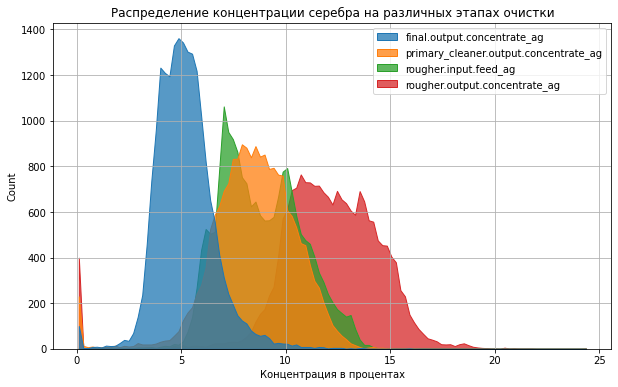

In [24]:
ax = sns.histplot(data_concentrate_ag, element = 'poly')

ax.set(title='Распределение концентрации серебра на различных этапах очистки',
              xlabel='Концентрация в процентах')
ax.grid(True)
ax.figure.set_size_inches(10, 6)
plt.show()

Промежуточный вывод: наибольшая концентрация серебра достигается на этапе финального выхода концентрата, наименьшей - в исходном сырье и после этапа флотации.

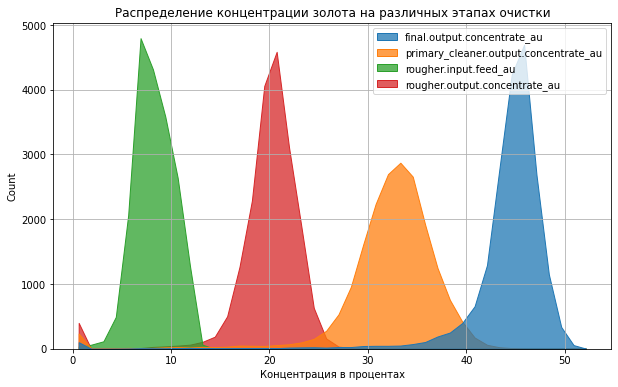

In [25]:
ax = sns.histplot(data_concentrate_au, element = 'poly')

ax.set(title='Распределение концентрации золота на различных этапах очистки',
              xlabel='Концентрация в процентах')
ax.grid(True)
ax.figure.set_size_inches(10, 6)
plt.show()

Промежуточный вывод: наибольшей концентрации золота достигается на этапе финального выхода концентрата, наименьшей - в исходном сырье. При этом исходя из анализа графиков, можно утверждать, что на каждом последующем этапе очистики концентрация золота увеличивается.

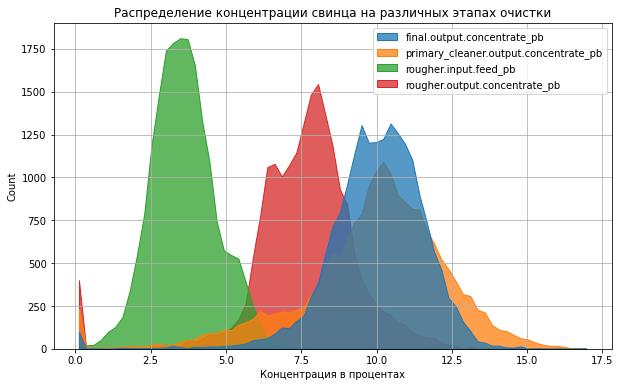

In [26]:
ax = sns.histplot(data_concentrate_pb, element = 'poly')

ax.set(title='Распределение концентрации свинца на различных этапах очистки',
              xlabel='Концентрация в процентах')
ax.grid(True)
ax.figure.set_size_inches(10, 6)
plt.show()

Промежуточный вывод: наибольшая концентрация свинца достигается на этапе финального выхода концентрата, наименьшей - в исходном сырье. При этом исходя из анализа графиков, можно утверждать, что на каждом последующем этапе очистики концентрация золота увеличивается.

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках графическим методом

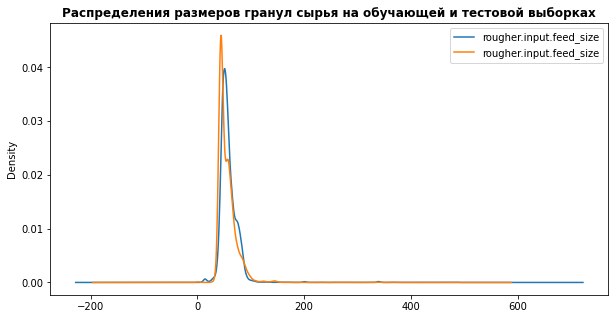

In [27]:
data_train_new['rougher.input.feed_size'].plot(kind='density', 
                                               label='rougher.input.feed_size', 
                                               legend=True, 
                                               figsize=(10, 5))
data_test_new['rougher.input.feed_size'].plot(kind='density', 
                                               label='rougher.input.feed_size', 
                                               legend=True, 
                                               figsize=(10, 5))
plt.title('Распределения размеров гранул сырья на обучающей и тестовой выборках', fontweight="bold")
plt.show()

Промежуточный вывод: графики показывают, что распределения схожи на обучающей и тестовой выборках, обучать и тестировать будущую модель на них можно.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [28]:
df_all_concentrate = data_train_new[columns_concentrate]

df_all_concentrate['rougher.input.feed_all'] = df_all_concentrate['rougher.input.feed_ag'] 
+ df_all_concentrate['rougher.input.feed_au'] 
+ df_all_concentrate['rougher.input.feed_pb']

df_all_concentrate['rougher.output.concentrate_all'] = df_all_concentrate['rougher.output.concentrate_ag'] 
+ df_all_concentrate['rougher.output.concentrate_au'] 
+ df_all_concentrate['rougher.output.concentrate_pb']

df_all_concentrate['primary_cleaner.output.concentrate_all']  = df_all_concentrate['primary_cleaner.output.concentrate_ag'] 
+ df_all_concentrate['primary_cleaner.output.concentrate_au'] 
+ df_all_concentrate['primary_cleaner.output.concentrate_pb']

df_all_concentrate['final.output.concentrate_all'] = df_all_concentrate['final.output.concentrate_ag'] 
+ df_all_concentrate['final.output.concentrate_au'] 
+ df_all_concentrate['final.output.concentrate_pb']

df_all_concentrate = df_all_concentrate.drop(labels=list(columns_concentrate), axis=1)

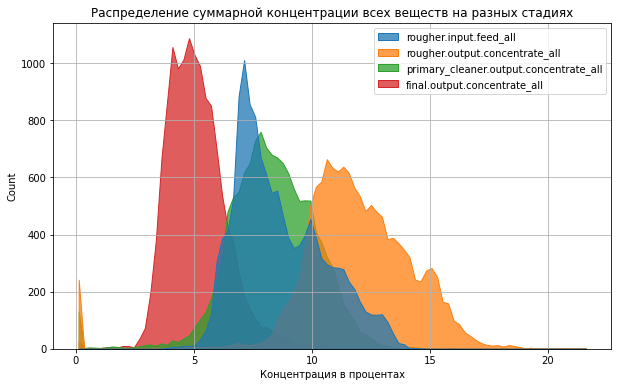

In [29]:
ax = sns.histplot(df_all_concentrate, element = 'poly')

ax.set(title='Распределение суммарной концентрации всех веществ на разных стадиях',
              xlabel='Концентрация в процентах')
ax.grid(True)
ax.figure.set_size_inches(10, 6)
plt.show()

## Модель

Удалим признаки, которые отсутствуют в тестовом датасете в обучающем датасете за исключением 2-х целевых признаков (rougher.output.recovery, final.output.recovery):

In [30]:
features_excluded_test.remove('rougher.output.recovery')
features_excluded_test.remove('final.output.recovery')
data_train_new = data_train_new.drop(labels=features_excluded_test, axis=1).reset_index(drop=True)
print('Количество признаков в новой обучающей выборке', len(data_train_new.columns))

Количество признаков в новой обучающей выборке 54


Выделим отдельно целевые и независимые признаки в обучающей выборке

In [31]:
target_train_rougher = data_train_new['rougher.output.recovery']
target_train_final = data_train_new['final.output.recovery']
to_drop_train = ['rougher.output.recovery', 'final.output.recovery']
features_train = data_train_new.drop(labels=to_drop_train, axis=1)

Выделим отдельно целевые и независимые признаки в тестовой выборке

In [32]:
target_test_rougher = data_test_new['rougher.output.recovery']
target_test_final = data_test_new['final.output.recovery']
to_drop_test = ['rougher.output.recovery', 'final.output.recovery', 'date']
features_test = data_test_new.drop(labels=to_drop_test, axis=1)

Напишем функцию для вычисления sMAPE(симметричной средней абсолютной ошибки в процентах), которая будет применяться отдельно для чернового и финального восстановления

In [33]:
def smape(target, prediction):
    abs_diff = abs(target - prediction) / ((abs(target) + abs(prediction)) / 2)
    N = len(abs_diff)
    smape = sum(abs_diff) / N * 100
    return round(smape, 2)

In [34]:
RANDOM_STATE=12345

Укажем метрику, которая будет минимизировать значение симметричной средней абсолютной ошибки в процентах (sMAPE)

In [35]:
SCORER = make_scorer(smape, greater_is_better= False)

In [36]:
smape_rougher = []
smape_final = []

Обучим модели линейной регрессии и подберем к ним оптимальные гиперпараметры c целью найти минимальное значение sMAPE для чернового и финального восстановления

In [37]:
%%time

model_lin_rougher = LinearRegression()
parameters_lin_rougher = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_lin_rougher = GridSearchCV(model_lin_rougher, parameters_lin_rougher, scoring=SCORER, n_jobs=-1, cv=5)
model_lin_rougher = grid_lin_rougher.fit(features_train, target_train_rougher)
print('Наименьшее значение sMAPE в модели линейной регресcии для чернового восстановления равно {} \n при следующих гиперпараметрах: {}'
      .format(-grid_lin_rougher.best_score_, grid_lin_rougher.best_params_))
smape_rougher.append(-grid_lin_rougher.best_score_)

Наименьшее значение sMAPE в модели линейной регресcии для чернового восстановления равно 10.73 
 при следующих гиперпараметрах: {'copy_X': True, 'fit_intercept': True, 'normalize': True}
CPU times: user 3.51 s, sys: 6.81 s, total: 10.3 s
Wall time: 10.3 s


In [38]:
%%time

model_lin_final = LinearRegression()
parameters_lin_final = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_lin_final = GridSearchCV(model_lin_final, parameters_lin_final, scoring=SCORER, n_jobs=-1, cv=5)
model_lin_final = grid_lin_final.fit(features_train, target_train_final)
print('Наименьшее значение sMAPE в модели линейной регресcии для финального восстановления равно {} \n при следующих гиперпараметрах: {}'
      .format(-grid_lin_final.best_score_, grid_lin_final.best_params_))
smape_final.append(-grid_lin_final.best_score_)

Наименьшее значение sMAPE в модели линейной регресcии для финального восстановления равно 10.373999999999999 
 при следующих гиперпараметрах: {'copy_X': True, 'fit_intercept': True, 'normalize': True}
CPU times: user 3.52 s, sys: 6.75 s, total: 10.3 s
Wall time: 10.3 s


Обучим модели случайного леса и подберем к ним оптимальные гиперпараметры c целью найти минимальное значение sMAPE для чернового и финального восстановления

In [39]:
%%time

model_rf_rougher = RandomForestRegressor(max_depth=2, random_state=RANDOM_STATE)
parameters_rf_rougher = {'n_estimators': range(80, 100, 20)}
grid_rf_rougher = GridSearchCV(model_rf_rougher,  parameters_rf_rougher, scoring=SCORER, n_jobs=-1, cv=5)
model_rf_rougher= grid_rf_rougher.fit(features_train, target_train_rougher)
print('Наименьшее значение sMAPE в модели случайного леса для чернового восстановления равно {} \n при следующих гиперпараметрах: {}'
      .format(-grid_rf_rougher.best_score_, grid_rf_rougher.best_params_))
smape_rougher.append(-grid_rf_rougher.best_score_)

Наименьшее значение sMAPE в модели случайного леса для чернового восстановления равно 11.392 
 при следующих гиперпараметрах: {'n_estimators': 80}
CPU times: user 33.7 s, sys: 354 ms, total: 34.1 s
Wall time: 35 s


In [40]:
%%time

model_rf_final = RandomForestRegressor(max_depth=2, random_state=RANDOM_STATE)
parameters_rf_final = {'n_estimators': range(80, 100, 20)}
grid_rf_final = GridSearchCV(model_rf_final,  parameters_rf_final, scoring=SCORER, n_jobs=-1, cv=5)
model_rf_final = grid_rf_final.fit(features_train, target_train_final)
print('Наименьшее значение sMAPE в модели случайного леса для финального восстановления равно {} \n при следующих гиперпараметрах: {}'
      .format(-grid_rf_final.best_score_, grid_rf_final.best_params_))
smape_final.append(-grid_rf_final.best_score_)

Наименьшее значение sMAPE в модели случайного леса для финального восстановления равно 9.164 
 при следующих гиперпараметрах: {'n_estimators': 80}
CPU times: user 33.3 s, sys: 146 ms, total: 33.4 s
Wall time: 33.4 s


Обучим модели дерева решений и подберем к ним оптимальные гиперпараметры c целью найти минимальное значение sMAPE для чернового и финального восстановления

In [41]:
%%time

model_dt_rougher = DecisionTreeRegressor(random_state=RANDOM_STATE)
parameters_dt_rougher = {'max_depth':range(2, 8, 2)}
grid_dt_rougher = GridSearchCV(model_dt_rougher,  parameters_dt_rougher, scoring=SCORER, n_jobs=-1, cv=5)
model_dt_rougher= grid_dt_rougher.fit(features_train, target_train_rougher)
print('Наименьшее значение sMAPE в модели дерева решений для чернового восстановления равно {} \n при следующих гиперпараметрах: {}'
      .format(-grid_dt_rougher.best_score_, grid_dt_rougher.best_params_))
smape_rougher.append(-grid_dt_rougher.best_score_)

Наименьшее значение sMAPE в модели дерева решений для чернового восстановления равно 10.748000000000001 
 при следующих гиперпараметрах: {'max_depth': 4}
CPU times: user 3.42 s, sys: 13.5 ms, total: 3.43 s
Wall time: 3.44 s


In [42]:
%%time

model_dt_final = DecisionTreeRegressor(random_state=RANDOM_STATE)
parameters_dt_final = {'max_depth':range(2, 8, 2)}
grid_dt_final = GridSearchCV(model_dt_final,  parameters_dt_final, scoring=SCORER, n_jobs=-1, cv=5)
model_dt_final = grid_dt_final.fit(features_train, target_train_final)
print('Наименьшее значение SMAPE в модели дерева решений для восстановления концентрата равно {} \n при следующих гиперпараметрах: {}'
      .format(-grid_dt_final.best_score_, grid_dt_final.best_params_))
smape_final.append(-grid_dt_final.best_score_)

Наименьшее значение SMAPE в модели дерева решений для восстановления концентрата равно 9.652 
 при следующих гиперпараметрах: {'max_depth': 2}
CPU times: user 3.2 s, sys: 16.5 ms, total: 3.22 s
Wall time: 3.23 s


Из построенных вариантов выберем минимальные значения sMAPE для чернового и финального восстановления

In [43]:
print('Минимальный sMAPE для чернового восстановления', min(smape_rougher))
print('Минимальный sMAPE для финального восстановления', min(smape_final))

Минимальный sMAPE для чернового восстановления 10.73
Минимальный sMAPE для финального восстановления 9.164


Промежуточный вывод: в результате выбраны 2 модели с минимальными sMAPE - модель линейной регрессии для чернового восстановления и модель случайного леса для финального восстановления

Проверим качество выбранных моделей на тестовой выборке, вычислив итоговую sMAPE для чернового и финального концентра, и сравнив ее со sMAPE константных моделей

In [44]:
model_best_rougher = LinearRegression(copy_X= True, fit_intercept= False, normalize=True)
model_best_rougher.fit(features_train, target_train_rougher)
predicted_test_rougher = model_best_rougher.predict(features_test)

model_best_final = RandomForestRegressor(max_depth=2, n_estimators=80, random_state=RANDOM_STATE)
model_best_final.fit(features_train, target_train_final)
predicted_test_final = model_best_final.predict(features_test)

SMAPE_FINAL = 0.25 * smape(target_test_rougher, predicted_test_rougher) + 0.75 * smape(target_test_final, predicted_test_final)

model_dummy_rougher = DummyRegressor(strategy = 'mean')
model_dummy_rougher.fit(features_train, target_train_rougher)
predicted_dummy_rougher = model_dummy_rougher.predict(features_test)

model_dummy_final = DummyRegressor(strategy = 'mean')
model_dummy_final.fit(features_train, target_train_final)
predicted_dummy_final = model_dummy_final.predict(features_test)

SMAPE_DUMMY = 0.25 * smape(target_test_rougher, predicted_dummy_rougher) + 0.75 * smape(target_test_final, predicted_dummy_final)

print('Итоговая sMAPE финальных моделей', SMAPE_FINAL)
print('sMAPE константных моделей', SMAPE_DUMMY)
if SMAPE_FINAL < SMAPE_DUMMY:
    print('Качество выбранных моделей лучше константных моделей')
elif SMAPE_FINAL >= SMAPE_DUMMY:
    print('Качество выбранных моделей не лучше константных моделей')  


Итоговая sMAPE финальных моделей 9.085
sMAPE константных моделей 9.602500000000001
Качество выбранных моделей лучше константных моделей


Вывод: в результате обучения моделей для прогнозирования коэффициентов восстановления золота в черновом и финальном концентрате были выбраны 2 модели с минимальными sMAPE (модель линейной регрессии для чернового восстановления и модель случайного леса для финального восстановления), которые успешно прошли тестирование по критерию итогового sMAPE в сравнении с констатными моделями.

## Вывод

В результате проведенного исследования были получены следующие результаты:

1. Подготовлены данные в обучающей и тестовой выборках для дальнейшего анализа и обучения.

2. Выявлено, что наибольшее значение концентрации из всех металлов именно золото достигает его на этапе финального выхода концентрата (40-50%). При этом суммарно по всем металлам наименьшая средняя суммарная концентрация достигается в руде, на остальных этапах концентрация металлов увеличивается.

3. Обучены разные модели, выбраны и протестированы 2 лучшие модели, прогнозирующие коэффициент восстановления золота из золотосодержащей руды для чернового и финального концентрата по критерию минимизации симметричной средней абсолютной процентной ошибки:

- для чернового концентрата - модель линейной регрессии со следующими параметрами: 
copy_X= True, fit_intercept= False, normalize=True

- для финального концентрата - модель случайного леса со следующими параметрами:
max_depth=2, n_estimators=80, random_state=12345.